Импорты:

In [1]:
import warnings
import pickle

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from  matplotlib import pyplot as plt

Отключение предупреждений:

In [2]:
warnings.filterwarnings('ignore')

Чтение данных:

In [3]:
df=pd.read_csv('../data/labeled/train.csv')

Определение целевой переменной и обучающегоо набора:

In [4]:
y=df['label']
x=df.drop(columns=['label'])

Посмотрю на рспределение объектов по классам:

Len: 28831
Cluster 1 part:  0.26
Cluster 2 part:  0.15
Cluster 3 part:  0.43
Cluster 4 part:  0.16


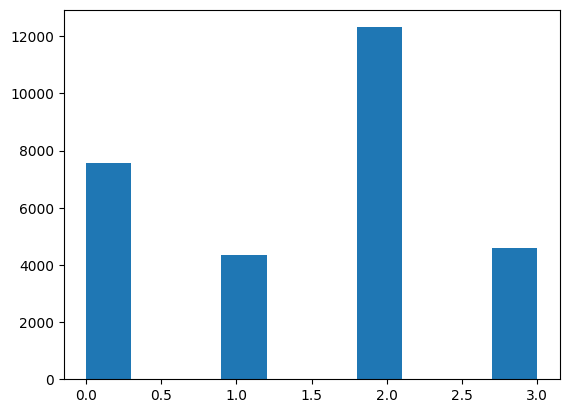

In [5]:
y.hist(grid=False)
full_lenght=len(y)
print('Len:', full_lenght)
for cluster in range(4):
    part=np.round(np.count_nonzero(y==cluster)/full_lenght,2)
    print(f'Cluster {cluster+1} part: ',part)    

Видим явную несбалансированность классов. Учту это при создании модели.

Разобью данные на тренировочные и тестовые:

In [6]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,stratify=y,random_state=0)

Создам простую линейную модель классификации с L2-регуляризатором и со скоректированными с учётом несбалансированности классов весами. Обучу модель и выведу метрику accuracy и матрицу ошибок:

Accuracy:  1.0


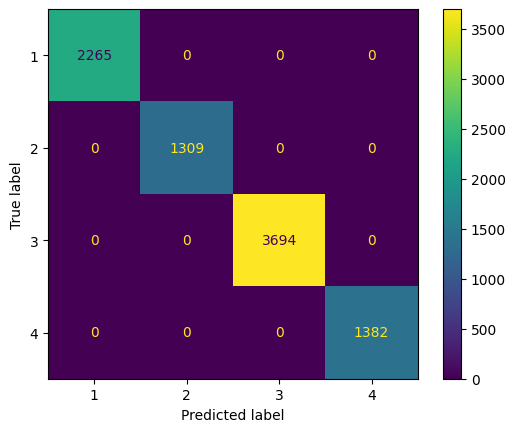

In [7]:
estimator_lin=LogisticRegression(class_weight='balanced')
estimator_lin.fit(x_train, y_train)
y_pred=estimator_lin.predict(x_test)

print('Accuracy: ',accuracy_score(y_test,y_pred))
cm = confusion_matrix(y_test, y_pred,labels=[0,1,2,3])
cmp = ConfusionMatrixDisplay(cm, display_labels=["1","2","3","4"])
cmp.plot();

Видим отличные результаты классификации - лучше некуда, оно не удивительно, ведь классы легко разделяются визуально в их, исходном, трёхмерном пространстве. Такую классификацию можно даже формальзовать небольшим набором правил. Сделаю это Деревом решений для задач классификации:

Accuracy:  1.0


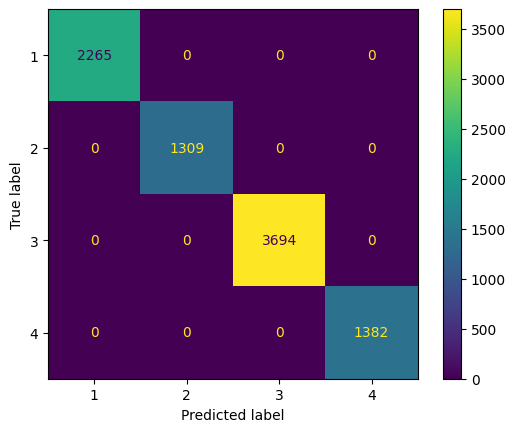

In [8]:
estimator_tree=DecisionTreeClassifier(max_depth=3)
estimator_tree.fit(x_train, y_train)
y_pred=estimator_tree.predict(x_test)

print('Accuracy: ',accuracy_score(y_test,y_pred))
cm = confusion_matrix(y_test, y_pred,labels=[0,1,2,3])
cmp = ConfusionMatrixDisplay(cm, display_labels=["1","2","3","4"])
cmp.plot();

Те же отличные значения метрик, теперь изображу данное дерево: 

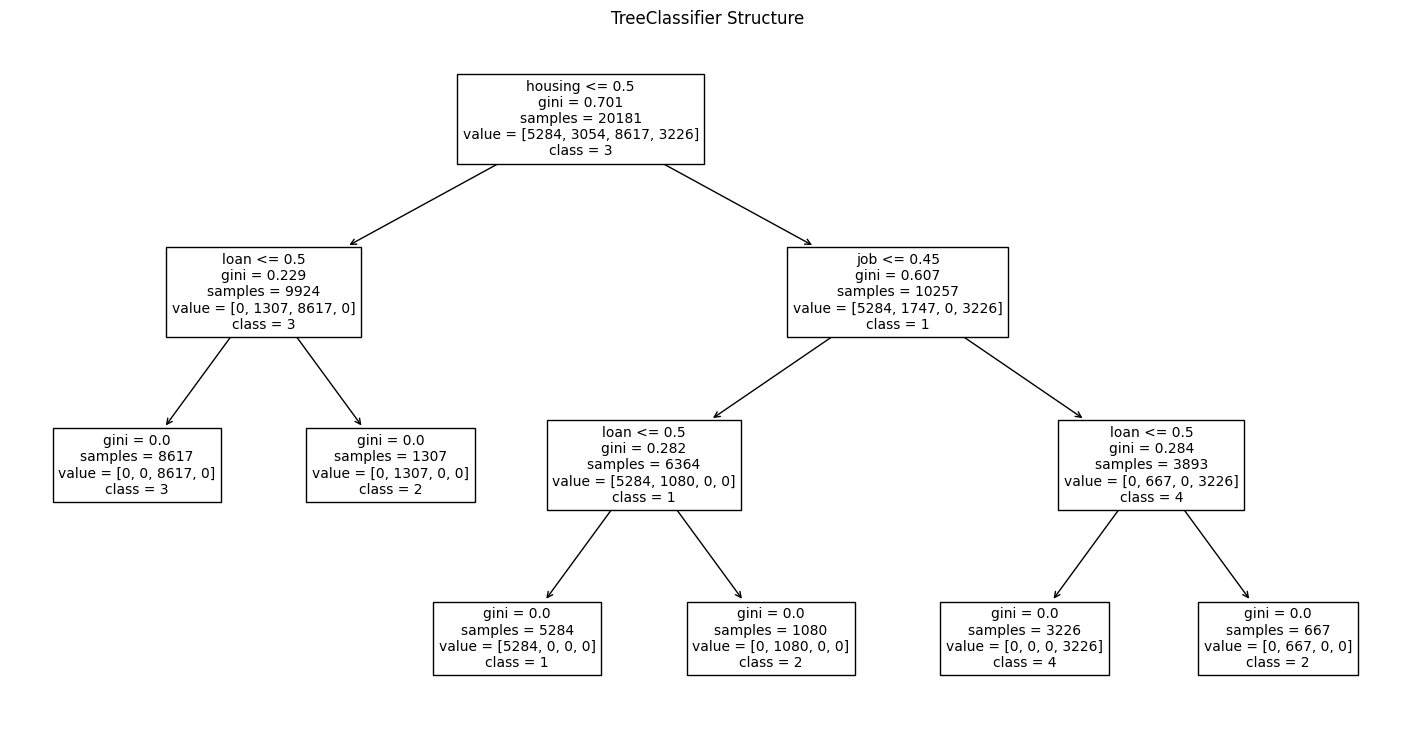

In [10]:
fig=plt.figure(figsize=(18,9))
plot_tree(decision_tree=estimator_tree,
          feature_names=list(x_train.columns),
          class_names=['1','2','3','4'],
          fontsize=10)
plt.title('TreeClassifier Structure')
plt.savefig('../models/model_structure.png')

with open('../app/model_structure.pkl','wb') as f:
    pickle.dump(fig,f)

Теперь наглядно можно увидеть алгоритм классификации, который построело Решающее дерево.

Данный алгоритм больше подходит для этой задачи, ведь все тири признака имеют конечный небольшой набор значений. Поэтому, данный алгоритм будет использоваться в приложении по класиификаци клиентов банка по категориям.

Посмотрю как классификатор работает на следующем датафрейме:

In [100]:
df_test=pd.read_csv('../data/labeled/test.csv')
label=df_test['label']
x_test=df_test.drop(columns=['label'])
y_preds=estimator_tree.predict(x_test)
print('Matching: ',accuracy_score(label,y_preds))

Matching:  1.0


Метки определённые при кластеризации полностью совпали с прогнозами классификатора.

Сохраню модель в каталог models/ для дальнейшего использования:

In [99]:
with open('../models/model.pkl','wb') as f:
    pickle.dump(estimator_tree,f)

ИТОГ

Задача разбиения клиентов банка на 3-4 кластера и настройка модели для дальнейшей классификации решена. В ходе детального анализа данный было установлено, что для оптимально будет разбить клиентов на 4 кластера и для этого достаточно всего 3-ех признаков из исходных 20, для более точечной кластеризации нужны будут и другие признаки. С задачей классификации по полученным кластерам легко справилось обычное Решающее дерево. Итоговая модель полностью интерпретируема, что важно в банковском деле.